In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from tqdm import tqdm
from scipy import stats
from statsmodels.stats.multitest import multipletests
import mne
import imageio
from collect_data import *
from collect_metrics import get_topomap

Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:57: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


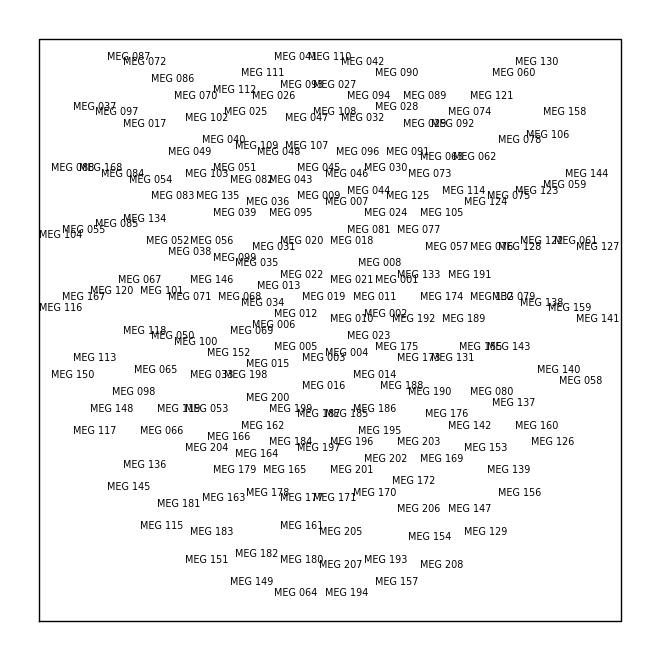

Figure(640x640)


In [2]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')
layout_from_raw = mne.channels.find_layout(raw.info, ch_type='mag')
print(layout_from_raw.plot())

In [3]:
path_brain_data = "/srv/nfs-data/sisko/matteoc/meg/brain_data"

In [4]:
brain_corr_null = torch.load(path_brain_data + "/00_brain_corr_null.pt")
brain_corr_true = torch.load(path_brain_data + "/00_brain_corr_tot.pt")
brain_pval_null = torch.load(path_brain_data + "/00_brain_pval_null.pt")

brain_pval_null_mean = torch.mean(brain_pval_null, dim=0)
brain_corr_null_mean = torch.mean(brain_corr_null, dim=0)
brain_corr_true_mean = torch.mean(brain_corr_true, dim=0)

100%|██████████| 8/8 [00:00<00:00, 54.35it/s]


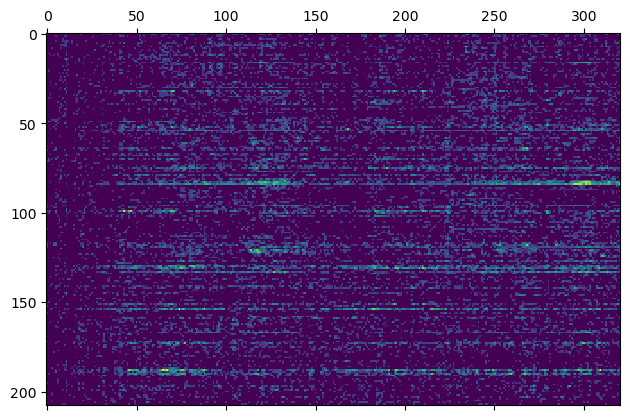

In [5]:
significant_corr_matrix = torch.zeros_like(brain_corr_true)
for i in tqdm(range(8)):
    _, corrected_p_values, _, _ = multipletests(brain_pval_null[i].cpu().numpy().flatten(), alpha=0.05, method='fdr_bh')
    corrected_p_values = corrected_p_values.reshape(brain_pval_null[i].cpu().numpy().shape)
    significant_corr = np.where(corrected_p_values < 0.05, brain_corr_true[i].cpu().numpy(), 0)
    significant_corr_matrix[i] = torch.tensor(significant_corr)

significant_corr_matrix = torch.mean(significant_corr_matrix.cpu(), dim=0)
plt.matshow(significant_corr_matrix)

In [6]:
t_values, p_values_ttest = stats.ttest_1samp(brain_corr_true_mean.cpu().numpy(), np.nanmean(brain_corr_null_mean.cpu(), axis=0), axis=0, nan_policy='omit')
_, corrected_p_values_ttest, _, _ = multipletests(p_values_ttest, alpha=0.05, method='fdr_bh')
significant_timesteps = corrected_p_values_ttest < 0.05

In [7]:
significant_timesteps

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [54]:
window_size = 5  
kernel = np.ones(window_size) / window_size

smoothed_matrix = np.array([
    np.convolve(channel, kernel, mode='valid') for channel in significant_corr_matrix.cpu().numpy()])

In [55]:
def get_topomap_gif(raw, correlations, timepoint, vlim, cmap='RdBu_r', sphere=0.13, extrapolate='local', 
                image_interp='cubic', threshold=None, size=8.5, label_to_set='Correlation'):
    meg_indices = mne.pick_types(raw.info, meg=True)
    meg_channel_positions = np.array([raw.info['chs'][i]['loc'][:2] for i in meg_indices])
    correlations = np.array(correlations).reshape(-1)
    if threshold is not None:
        correlations = np.where(correlations > threshold, correlations, np.nan)
    
    fig, ax = plt.subplots()
    topomap = mne.viz.plot_topomap(correlations, meg_channel_positions, ch_type='meg',
                                   names=raw.info['ch_names'], sphere=sphere,
                                   image_interp=image_interp, extrapolate=extrapolate,
                                   border='mean', size=size, cmap=cmap, axes=ax, 
                                   vlim=vlim, show=False)
    cbar = plt.colorbar(topomap[0], ax=ax, fraction=0.02, pad=0.1)   
    cbar.set_label(label_to_set)
    fig.set_size_inches(10, 8)
    ax.set_title(f'Timepoint {timepoint}', fontsize=16)
    fig.canvas.draw()
    
    # Convert figure to numpy array
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return img

In [56]:
gif_path = 'topographic_animation.gif'

def get_topog_animation(corr_matrix):
    frames = []
    for time_points in tqdm(range(corr_matrix.shape[1])):
        plot_data = corr_matrix[:, time_points]
        correlations = get_topomap_gif(raw, plot_data, time_points, (corr_matrix.min(), corr_matrix.max()), threshold=None,
                    image_interp='cubic', cmap='RdYlGn', label_to_set='Z-Scores')  # RdYlGn_r
        frames.append(correlations)

    # imageio.mimsave(gif_path, frames, duration=1)
    # Save frames as GIF using a specified FPS for slower playback
    with imageio.get_writer(gif_path, mode='I', fps=2) as writer:  # Decrease fps for a slower GIF
        for frame in frames:
            writer.append_data(frame)

get_topog_animation(smoothed_matrix)

100%|██████████| 317/317 [01:43<00:00,  3.07it/s]
